In [1]:
%matplotlib inline

import os
import sys

import polars as pl
import pandas as pd
import numpy as np
import matplotlib as plt
import mplfinance as mpf
from tqdm import tqdm
from datetime import date, timedelta, datetime, timezone

from binance_utility.plot_utils import plot_correlation

In [2]:
# 約定履歴21日分を読み込む。あらかじめdownload_trades.pyを使ってデータファイルをダウンロードしておくこと。
days = 30
symbol = "BTCUSDT"

# 指定日から30日前までのデータを使いたい場合
last_date = date(year=2023, month=5, day=5)
# 昨日から30日前までのデータを使いたい場合
# last_date = (datetime.now(timezone.utc) - timedelta(days = 2)).date()
start_date = last_date - timedelta(days=days)

if "df_trades" in globals():
    del df_trades

df_trades = None
date_cursor = start_date

while date_cursor <= last_date:
    if df_trades is None:
        df_trades = pl.read_parquet(f"/home/jovyan/work/binance_utility/data/{symbol}_TRADES_{date_cursor.year:04d}-{date_cursor.month:02d}-{date_cursor.day:02d}.parquet")
    else:
        df_trades = df_trades.vstack(pl.read_parquet(f"/home/jovyan/work/binance_utility/data/{symbol}_TRADES_{date_cursor.year:04d}-{date_cursor.month:02d}-{date_cursor.day:02d}.parquet"))
    date_cursor = date_cursor + timedelta(days=1)

df_trades = df_trades.with_columns([(pl.when(pl.col("side") == "a").then(-pl.col("qty")).otherwise(pl.col("qty"))).alias("qty")]).sort("timestamp")

# タイムバー作成用パラメータ
groupby_interval_min = 15
groupby_interval_msec = groupby_interval_min * 60 * 1000

df_timebar = df_trades.groupby_dynamic("timestamp", every=f"{int(groupby_interval_msec)}i", closed="left").agg([pl.col("price").first().alias("open"), pl.col("price").max().alias("high"), pl.col("price").min().alias("low"), pl.col("price").last().alias("close"), np.abs(pl.col("qty")).sum().alias("volume"), pl.col("qty").sum().alias("qty_sum"), (pl.col("price").std()).alias("real_sigma")])
df_timebar = df_timebar.with_columns([((pl.col("close") - pl.col("open")) / pl.col("open")).alias("pct_change_price"), (pl.col("close") - pl.col("open")).alias("delta_price")])

argument is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    


100%|██████████| 2112/2112 [00:01<00:00, 1577.66it/s]
/opt/conda/lib/python3.10/site-packages/mplfinance/_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


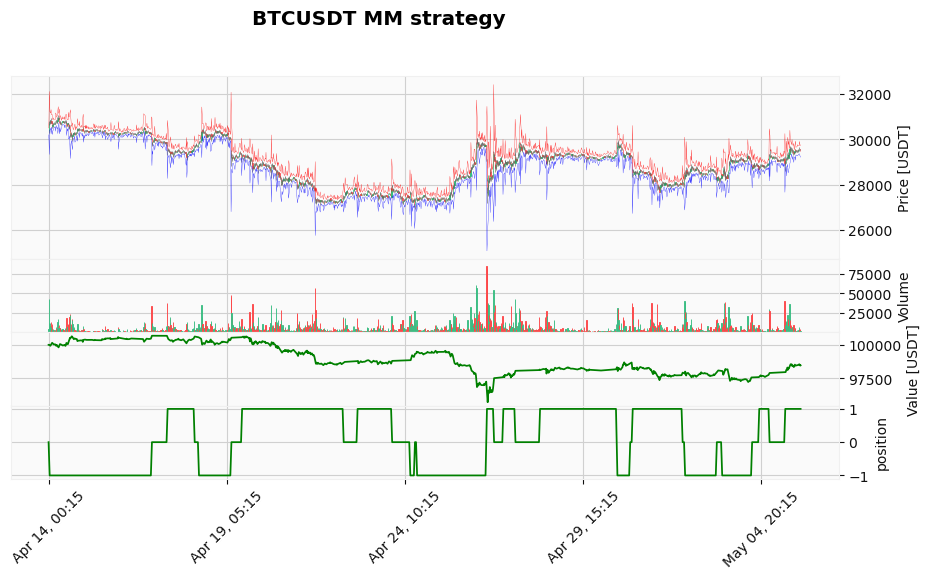

timestamp,open,high,low,close,volume,qty_sum,real_sigma,pct_change_price,delta_price,bid_price,ask_price,q,cash,value
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64
1681430400000,30362.7,30370.3,30334.1,30347.1,2340.601,-453.929,10.817258,-0.000514,-15.6,NaN,NaN,0.0,100000,0.0
1681431300000,30347.2,30409.8,30293.0,30386.7,4043.53,416.412,29.983463,0.001302,39.5,30198.29,30495.91,0.0,100000,100000.0
1681432200000,30386.8,30822.8,30364.7,30721.9,42852.661,6622.333,121.356643,0.011028,335.1,30022.3,30751.1,-1.0,130744,100023.04978
1681433100000,30721.9,30768.1,30641.8,30741.3,12533.362,-1036.196,28.412837,0.000631,19.4,29329.7,32114.1,-1.0,130744,100002.7
1681434000000,30741.4,30850.0,30704.9,30814.9,12591.341,1012.045,32.143596,0.002391,73.5,30394.57,31088.03,-1.0,130744,99929.1
1681434900000,30814.8,30830.0,30681.0,30770.9,8806.14,-887.758,36.11162,-0.001425,-43.9,30426.2,31203.6,-1.0,130744,99973.1
1681435800000,30770.8,30835.4,30722.2,30817.8,8496.297,708.077,27.553911,0.001527,47.0,30337.57,31204.23,-1.0,130744,99926.2
1681436700000,30817.7,30950.0,30750.0,30776.4,12891.74,613.714,44.919466,-0.00134,-41.3,30480.73,31154.87,-1.0,130744,99967.6
1681437600000,30776.3,30811.7,30711.1,30805.4,6661.243,239.439,21.93148,0.000946,29.1,30244.0,31308.8,-1.0,130744,99938.6


In [67]:
# 指値幅の計算パラメータ
params = {
    "position_abs_max": 1,
    "lambda": 1 / (groupby_interval_min * 60),
    "delta": 1,
    "a": 226.98638124,
    "alpha": 1.1254549,
    "b": 3.0534806e+01,
    "c": 1.2302710e-02,
    "gamma": 250
}

params["A"] = params["lambda"] / params["alpha"] * params["a"] / params["c"]
params["k"] = params["alpha"] / params["b"]



# timebarデータフレームに計算した指値やポジション、損益を追加する
initial_cash = 100_000
fee = 0.0002

df_timebar = df_timebar.with_columns([pl.lit(np.nan).alias("bid_price"), pl.lit(np.nan).alias("ask_price"), pl.lit(0.0).alias("q"), pl.lit(0).alias("cash"), pl.lit(0.0).alias("value")])
df_timebar[0, "cash"] = initial_cash

# シミュレーションの準備
_prev_row = None

# 指値幅の計算
df_timebar_num_rows = df_timebar.shape[0]
for _idx in tqdm(range(0, df_timebar_num_rows)):
    # 最後の行は指値幅計算をしない
    if _idx < df_timebar_num_rows - 1:
        df_timebar[_idx + 1, "bid_price"] = np.round(df_timebar[_idx, "close"] - (1 / params["k"] + (2 * df_timebar[_idx, "q"] + params["delta"]) / 2 * np.sqrt((params["gamma"] * df_timebar[_idx, "real_sigma"] ** 2 * np.e) / (2 * params["A"] * params["delta"] * params["k"]))), 2)
        df_timebar[_idx + 1, "ask_price"] = np.round(df_timebar[_idx, "close"] + (1 / params["k"] - (2 * df_timebar[_idx, "q"] - params["delta"]) / 2 * np.sqrt((params["gamma"] * df_timebar[_idx, "real_sigma"] ** 2 * np.e) / (2 * params["A"] * params["delta"] * params["k"]))), 2)

    # 最初の行はトレードの計算をしない                                
    if _idx == 0:
        continue
    
    # 指値ヒットなど
    _is_bid_hit = df_timebar[_idx, "bid_price"] >= df_timebar[_idx, "low"]
    _is_ask_hit = df_timebar[_idx, "ask_price"] <= df_timebar[_idx, "high"]
    _cash = df_timebar[_idx - 1, "cash"]
    _q = df_timebar[_idx - 1, "q"]

    # Buyの処理
    if _is_bid_hit:
        if _q < params["position_abs_max"]:
            _delta = params["delta"] if _q + params["delta"] <= params["position_abs_max"] else params["position_abs_max"] - _q
            if _cash >= _delta * df_timebar[_idx, "bid_price"]:
                _q = _q + _delta
                _cash = _cash - (1 + fee) * _delta * df_timebar[_idx, "bid_price"]
    # Sellの処理
    if _is_ask_hit:
        if _q > -params["position_abs_max"]:
            _delta = params["delta"] if _q - params["delta"] >= -params["position_abs_max"] else np.abs(-params["position_abs_max"] - _q)
            _q = _q - _delta
            _cash = _cash + (1 - fee) * _delta * df_timebar[_idx, "ask_price"]
    
    # Valueの計算など
    df_timebar[_idx, "q"] = _q
    df_timebar[_idx, "cash"] = _cash
    df_timebar[_idx, "value"] = _cash + _q * df_timebar[_idx, "close"]

# 表示用データフレームの作成
df_timebar_pd = df_timebar.to_pandas().dropna()
df_timebar_pd["datetime"] = pd.to_datetime(df_timebar_pd["timestamp"], unit="ms")
df_timebar_pd = df_timebar_pd.set_index("datetime", drop = True)
df_timebar_pd_filtered = df_timebar_pd
#df_timebar_pd_filtered = df_timebar_pd[(df_timebar_pd.index > "2023-04-25") & (df_timebar_pd.index < "2023-04-26")]

# プロット
additional_plot = [mpf.make_addplot(df_timebar_pd_filtered["value"], type="line", color="green", ylabel="Value [USDT]", panel=2),
                   mpf.make_addplot(df_timebar_pd_filtered["q"], type="line", color="green", ylabel="position", panel=3),
                   mpf.make_addplot(df_timebar_pd_filtered["bid_price"], type="line", color="blue", width=0.2),
                   mpf.make_addplot(df_timebar_pd_filtered["ask_price"], type="line", color="red", width=0.2)]
mpf.plot(df_timebar_pd_filtered, type="candle", title=f"{symbol} MM strategy", ylabel="Price [USDT]", style="yahoo", figratio=(12, 6), addplot = additional_plot, volume=True)

display(df_timebar)